In [37]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [38]:
pip install pytorch-lightning  

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [39]:
pip install pytorch-forecasting

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [40]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [41]:
import os
import warnings
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
import optuna

from typing import Any, Callable, Dict, List, Optional, Tuple, Union
from sklearn.preprocessing import MinMaxScaler


import torch
import torch.nn.functional as F
from torch import distributions

import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_forecasting.data.examples import generate_ar_data

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet, QuantileLoss
from pytorch_forecasting.data import NaNLabelEncoder
from pytorch_forecasting.metrics import SMAPE, DistributionLoss, NormalDistributionLoss, LogNormalDistributionLoss, BaseEstimator
from pytorch_forecasting.data.encoders import GroupNormalizer
import tensorflow as tf 
import tensorboard as tb 
tf.io.gfile = tb.compat.tensorflow_stub.io.gfile

warnings.filterwarnings('ignore')
%matplotlib inline

In [42]:
data = pd.read_excel('/content/drive/MyDrive/교육/AI실무인증과정/학회 발표/data/data_full.xlsx')
data.head()

Date Account DOW  REV OBD  OBD NET+FSC_KRW  OBD A/R_KRW  REV CPN  \
0 2016-01-01         FRI  25196.0     9.923237e+09  393841.7444   5517.0   
1 2016-01-02         SAT  27495.0     1.106671e+10  402499.1654   6320.0   
2 2016-01-03         SUN  31843.0     1.270800e+10  399083.0044   4292.0   
3 2016-01-04         MON  28000.0     1.154173e+10  412204.5697  36263.0   
4 2016-01-05         TUE  24657.0     1.008791e+10  409129.4946  38432.0   

   CPN NET+FSC_KRW  CPN A/R_KRW  REV TKT  TKT NET+FSC_KRW  TKT A/R_KRW    WTI  \
0     2.410238e+09  436874.6714   3188.0     2.236210e+09  701446.0183   0.00   
1     2.500112e+09  395587.3387   3577.0     2.405358e+09  672451.2796   0.00   
2     1.813688e+09  422573.9862   2521.0     1.697046e+09  673163.7338   0.00   
3     1.465623e+10  404164.9715  19528.0     1.454451e+10  744803.0601  36.76   
4     1.538667e+10  400360.8701  20461.0     1.555175e+10  760067.7182  35.97   

   exchanges    kospi  rates  stock_a  stock_k  stock_kkj  
0        0.0     0.00   0.00      0.0      0.0        0.0  
1        0.0     0.00   0.00      0.0      0.0        0.0  
2        0.0     0.00   0.00      0.0      0.0        0.0  
3     1189.5  1918.76   1.63  21429.0  16459.0   108918.0  
4     1189.5  1930.53   1.64  20881.0  16186.0   108918.0

In [43]:
data.tail()

Date Account DOW  REV OBD  OBD NET+FSC_KRW   OBD A/R_KRW  REV CPN  \
1853 2021-01-27         WED   1099.0      872488809.0  7.938934e+05    557.0   
1854 2021-01-28         THU    369.0      346194072.0  9.381953e+05    686.0   
1855 2021-01-29         FRI    929.0      697137374.0  7.504170e+05    682.0   
1856 2021-01-30         SAT    504.0      394144488.0  7.820327e+05    261.0   
1857 2021-01-31         SUN    461.0      463553317.0  1.005539e+06    302.0   

      CPN NET+FSC_KRW   CPN A/R_KRW  REV TKT  TKT NET+FSC_KRW   TKT A/R_KRW  \
1853     4.829877e+08  8.671234e+05    446.0     5.687120e+08  1.275139e+06   
1854     5.998695e+08  8.744453e+05    533.0     6.906058e+08  1.295696e+06   
1855     6.035898e+08  8.850290e+05    540.0     6.792015e+08  1.257780e+06   
1856     2.191663e+08  8.397174e+05    186.0     2.128566e+08  1.144391e+06   
1857     3.645140e+08  1.207000e+06    215.0    -1.330932e+08 -6.190380e+05   

        WTI  exchanges    kospi  rates  stock_a  stock_k  stock_kkj  
1853  52.85     1105.0  3122.56   0.98  17302.0  30400.0    59587.0  
1854  52.34     1118.0  3069.05   0.97  17023.0  29650.0    58220.0  
1855  52.20     1117.5  2976.21   0.97  16353.0  28700.0    56657.0  
1856  52.20     1117.5  2976.21   0.97  16353.0  28700.0    56657.0  
1857  52.20     1117.5  2976.21   0.97  16353.0  28700.0    56657.0

In [44]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1858 entries, 0 to 1857
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Date             1858 non-null   datetime64[ns]
 1   Account DOW      1858 non-null   object        
 2   REV OBD          1858 non-null   float64       
 3   OBD NET+FSC_KRW  1858 non-null   float64       
 4   OBD A/R_KRW      1858 non-null   float64       
 5   REV CPN          1858 non-null   float64       
 6   CPN NET+FSC_KRW  1858 non-null   float64       
 7   CPN A/R_KRW      1858 non-null   float64       
 8   REV TKT          1858 non-null   float64       
 9   TKT NET+FSC_KRW  1858 non-null   float64       
 10  TKT A/R_KRW      1858 non-null   float64       
 11  WTI              1858 non-null   float64       
 12  exchanges        1858 non-null   float64       
 13  kospi            1858 non-null   float64       
 14  rates            1858 non-null   float64

In [45]:
res_data = data[data["Date"].isin(pd.date_range('2016-01-4', '2019-11-30'))]
res_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1427 entries, 3 to 1429
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Date             1427 non-null   datetime64[ns]
 1   Account DOW      1427 non-null   object        
 2   REV OBD          1427 non-null   float64       
 3   OBD NET+FSC_KRW  1427 non-null   float64       
 4   OBD A/R_KRW      1427 non-null   float64       
 5   REV CPN          1427 non-null   float64       
 6   CPN NET+FSC_KRW  1427 non-null   float64       
 7   CPN A/R_KRW      1427 non-null   float64       
 8   REV TKT          1427 non-null   float64       
 9   TKT NET+FSC_KRW  1427 non-null   float64       
 10  TKT A/R_KRW      1427 non-null   float64       
 11  WTI              1427 non-null   float64       
 12  exchanges        1427 non-null   float64       
 13  kospi            1427 non-null   float64       
 14  rates            1427 non-null   float64

In [46]:
res_data.reset_index(drop=True, inplace=True)

In [47]:
res_data

Date Account DOW  REV OBD  OBD NET+FSC_KRW  OBD A/R_KRW  REV CPN  \
0    2016-01-04         MON  28000.0     1.154173e+10  412204.5697  36263.0   
1    2016-01-05         TUE  24657.0     1.008791e+10  409129.4946  38432.0   
2    2016-01-06         WED  26920.0     1.009247e+10  374905.8415  41478.0   
3    2016-01-07         THU  26624.0     1.060220e+10  398219.6596  49006.0   
4    2016-01-08         FRI  28879.0     1.077601e+10  373143.3549  63847.0   
...         ...         ...      ...              ...          ...      ...   
1422 2019-11-26         TUE  22295.0     7.106925e+09  318767.6722  33929.0   
1423 2019-11-27         WED  25134.0     8.100108e+09  322276.9318  35642.0   
1424 2019-11-28         THU  24742.0     8.116231e+09  328034.5456  35459.0   
1425 2019-11-29         FRI  29624.0     9.924881e+09  335028.3726  41190.0   
1426 2019-11-30         SAT  25647.0     9.418206e+09  367224.4518  10238.0   

      CPN NET+FSC_KRW  CPN A/R_KRW  REV TKT  TKT NET+FSC_KRW  TKT A/R_KRW  \
0        1.465623e+10  404164.9715  19528.0     1.454451e+10  744803.0601   
1        1.538667e+10  400360.8701  20461.0     1.555175e+10  760067.7182   
2        1.597113e+10  385050.5604  21953.0     1.647945e+10  750669.3999   
3        1.798140e+10  366922.4713  25917.0     1.872443e+10  722476.6906   
4        2.480722e+10  388541.6089  33748.0     2.598923e+10  770096.9727   
...               ...          ...      ...              ...          ...   
1422     1.501046e+10  442407.9889  18388.0     1.618648e+10  880274.0396   
1423     1.487445e+10  417329.2423  19304.0     1.609138e+10  833577.7006   
1424     1.549214e+10  436902.7653  19087.0     1.674230e+10  877157.3571   
1425     1.766483e+10  428862.0799  22167.0     1.915980e+10  864338.9685   
1426     3.817682e+09  372893.3201   5739.0     4.090404e+09  712738.1535   

        WTI  exchanges    kospi  rates  stock_a  stock_k  stock_kkj  
0     36.76     1189.5  1918.76   1.63  21429.0  16459.0   108918.0  
1     35.97     1189.5  1930.53   1.64  20881.0  16186.0   108918.0  
2     33.97     1200.0  1925.43   1.64  20785.0  16063.0   110383.0  
3     33.27     1200.2  1904.33   1.64  20809.0  16003.0   104522.0  
4     33.16     1199.5  1917.62   1.67  20523.0  15637.0   105499.0  
...     ...        ...      ...    ...      ...      ...        ...  
1422  58.41     1177.5  2121.35   1.48  26679.0  16567.0    47670.0  
1423  58.11     1177.5  2127.85   1.46  26250.0  16438.0    46986.0  
1424  58.11     1179.0  2118.60   1.43  26059.0  16470.0    46937.0  
1425  55.17     1180.0  2087.96   1.39  25391.0  16048.0    47426.0  
1426  55.17     1180.0  2087.96   1.39  25391.0  16048.0    47426.0  

[1427 rows x 18 columns]

In [48]:
res_data['time_index'] = np.arange(len(res_data))
res_data['time_index'] = res_data['time_index'].astype(int)

In [49]:
res_data

Date Account DOW  REV OBD  OBD NET+FSC_KRW  OBD A/R_KRW  REV CPN  \
0    2016-01-04         MON  28000.0     1.154173e+10  412204.5697  36263.0   
1    2016-01-05         TUE  24657.0     1.008791e+10  409129.4946  38432.0   
2    2016-01-06         WED  26920.0     1.009247e+10  374905.8415  41478.0   
3    2016-01-07         THU  26624.0     1.060220e+10  398219.6596  49006.0   
4    2016-01-08         FRI  28879.0     1.077601e+10  373143.3549  63847.0   
...         ...         ...      ...              ...          ...      ...   
1422 2019-11-26         TUE  22295.0     7.106925e+09  318767.6722  33929.0   
1423 2019-11-27         WED  25134.0     8.100108e+09  322276.9318  35642.0   
1424 2019-11-28         THU  24742.0     8.116231e+09  328034.5456  35459.0   
1425 2019-11-29         FRI  29624.0     9.924881e+09  335028.3726  41190.0   
1426 2019-11-30         SAT  25647.0     9.418206e+09  367224.4518  10238.0   

      CPN NET+FSC_KRW  CPN A/R_KRW  REV TKT  TKT NET+FSC_KRW  TKT A/R_KRW  \
0        1.465623e+10  404164.9715  19528.0     1.454451e+10  744803.0601   
1        1.538667e+10  400360.8701  20461.0     1.555175e+10  760067.7182   
2        1.597113e+10  385050.5604  21953.0     1.647945e+10  750669.3999   
3        1.798140e+10  366922.4713  25917.0     1.872443e+10  722476.6906   
4        2.480722e+10  388541.6089  33748.0     2.598923e+10  770096.9727   
...               ...          ...      ...              ...          ...   
1422     1.501046e+10  442407.9889  18388.0     1.618648e+10  880274.0396   
1423     1.487445e+10  417329.2423  19304.0     1.609138e+10  833577.7006   
1424     1.549214e+10  436902.7653  19087.0     1.674230e+10  877157.3571   
1425     1.766483e+10  428862.0799  22167.0     1.915980e+10  864338.9685   
1426     3.817682e+09  372893.3201   5739.0     4.090404e+09  712738.1535   

        WTI  exchanges    kospi  rates  stock_a  stock_k  stock_kkj  \
0     36.76     1189.5  1918.76   1.63  21429.0  16459.0   108918.0   
1     35.97     1189.5  1930.53   1.64  20881.0  16186.0   108918.0   
2     33.97     1200.0  1925.43   1.64  20785.0  16063.0   110383.0   
3     33.27     1200.2  1904.33   1.64  20809.0  16003.0   104522.0   
4     33.16     1199.5  1917.62   1.67  20523.0  15637.0   105499.0   
...     ...        ...      ...    ...      ...      ...        ...   
1422  58.41     1177.5  2121.35   1.48  26679.0  16567.0    47670.0   
1423  58.11     1177.5  2127.85   1.46  26250.0  16438.0    46986.0   
1424  58.11     1179.0  2118.60   1.43  26059.0  16470.0    46937.0   
1425  55.17     1180.0  2087.96   1.39  25391.0  16048.0    47426.0   
1426  55.17     1180.0  2087.96   1.39  25391.0  16048.0    47426.0   

      time_index  
0              0  
1              1  
2              2  
3              3  
4              4  
...          ...  
1422        1422  
1423        1423  
1424        1424  
1425        1425  
1426        1426  

[1427 rows x 19 columns]

In [50]:
res_data.keys()

Index(['Date', 'Account DOW', 'REV OBD', 'OBD NET+FSC_KRW', 'OBD A/R_KRW',
       'REV CPN', 'CPN NET+FSC_KRW', 'CPN A/R_KRW', 'REV TKT',
       'TKT NET+FSC_KRW', 'TKT A/R_KRW', 'WTI', 'exchanges', 'kospi', 'rates',
       'stock_a', 'stock_k', 'stock_kkj', 'time_index'],
      dtype='object')

In [51]:
# Scaling
scaler = MinMaxScaler()
scale_col = ['REV OBD', 'OBD NET+FSC_KRW', 'OBD A/R_KRW', 'REV CPN',
             'CPN NET+FSC_KRW', 'CPN A/R_KRW', 'REV TKT', 'TKT NET+FSC_KRW',
             'TKT A/R_KRW', 'WTI', 'exchanges', 'kospi', 'rates',
             'stock_a', 'stock_k', 'stock_kkj']
scaled = scaler.fit_transform(res_data[scale_col])
scaled.shape

(1427, 16)

In [52]:
tmp_df_1 = res_data[['time_index', 'Date', 'Account DOW']]
columns = ['REV OBD', 'OBD NET+FSC_KRW', 'OBD A/R_KRW', 'REV CPN',
           'CPN NET+FSC_KRW', 'CPN A/R_KRW', 'REV TKT', 'TKT NET+FSC_KRW',
           'TKT A/R_KRW', 'WTI', 'exchanges', 'kospi', 'rates',
           'stock_a', 'stock_k', 'stock_kkj']
tmp_df_2 = pd.DataFrame(scaled, columns=columns)
res_data = pd.concat([tmp_df_1, tmp_df_2], axis=1)
res_data

time_index       Date Account DOW   REV OBD  OBD NET+FSC_KRW  \
0              0 2016-01-04         MON  0.346259         0.326659   
1              1 2016-01-05         TUE  0.218042         0.241049   
2              2 2016-01-06         WED  0.304836         0.241318   
3              3 2016-01-07         THU  0.293484         0.271334   
4              4 2016-01-08         FRI  0.379972         0.281569   
...          ...        ...         ...       ...              ...   
1422        1422 2019-11-26         TUE  0.127450         0.065511   
1423        1423 2019-11-27         WED  0.236336         0.123995   
1424        1424 2019-11-28         THU  0.221302         0.124945   
1425        1425 2019-11-29         FRI  0.408545         0.231449   
1426        1426 2019-11-30         SAT  0.256012         0.201613   

      OBD A/R_KRW   REV CPN  CPN NET+FSC_KRW  CPN A/R_KRW   REV TKT  \
0        0.374062  0.382432         0.410254     0.477330  0.390738   
1        0.366526  0.407230         0.432465     0.456675  0.411128   
2        0.282653  0.442056         0.450237     0.373548  0.443735   
3        0.339789  0.528126         0.511364     0.275121  0.530367   
4        0.278334  0.697807         0.718921     0.392503  0.701510   
...           ...       ...              ...          ...       ...   
1422     0.145074  0.355746         0.421025     0.684971  0.365824   
1423     0.153675  0.375332         0.416889     0.548806  0.385843   
1424     0.167785  0.373239         0.435672     0.655080  0.381100   
1425     0.184925  0.438763         0.501738     0.611423  0.448412   
1426     0.263828  0.084881         0.080679     0.307540  0.089385   

      TKT NET+FSC_KRW  TKT A/R_KRW       WTI  exchanges     kospi     rates  \
0            0.500458     0.532091  0.210159   0.722372  0.109423  0.439024   
1            0.506018     0.533700  0.194422   0.722372  0.124851  0.447154   
2            0.511139     0.532709  0.154582   0.778976  0.118166  0.447154   
3            0.523532     0.529736  0.140637   0.780054  0.090509  0.447154   
4            0.563636     0.534758  0.138446   0.776280  0.107929  0.471545   
...               ...          ...       ...        ...       ...       ...   
1422         0.509522     0.546376  0.641434   0.657682  0.374972  0.317073   
1423         0.508997     0.541452  0.635458   0.657682  0.383492  0.300813   
1424         0.512590     0.546047  0.635458   0.665768  0.371368  0.276423   
1425         0.525936     0.544695  0.576892   0.671159  0.331206  0.243902   
1426         0.442749     0.528709  0.576892   0.671159  0.331206  0.243902   

       stock_a   stock_k  stock_kkj  
0     0.223500  0.211446   0.847607  
1     0.200986  0.186607   0.847607  
2     0.197042  0.175416   0.865189  
3     0.198028  0.169957   0.794849  
4     0.186278  0.136657   0.806574  
...        ...       ...        ...  
1422  0.439195  0.221272   0.112549  
1423  0.421569  0.209535   0.104340  
1424  0.413722  0.212447   0.103752  
1425  0.386278  0.174051   0.109620  
1426  0.386278  0.174051   0.109620  

[1427 rows x 19 columns]

In [53]:
res_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1427 entries, 0 to 1426
Data columns (total 19 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   time_index       1427 non-null   int64         
 1   Date             1427 non-null   datetime64[ns]
 2   Account DOW      1427 non-null   object        
 3   REV OBD          1427 non-null   float64       
 4   OBD NET+FSC_KRW  1427 non-null   float64       
 5   OBD A/R_KRW      1427 non-null   float64       
 6   REV CPN          1427 non-null   float64       
 7   CPN NET+FSC_KRW  1427 non-null   float64       
 8   CPN A/R_KRW      1427 non-null   float64       
 9   REV TKT          1427 non-null   float64       
 10  TKT NET+FSC_KRW  1427 non-null   float64       
 11  TKT A/R_KRW      1427 non-null   float64       
 12  WTI              1427 non-null   float64       
 13  exchanges        1427 non-null   float64       
 14  kospi            1427 non-null   float64

In [54]:
res_data.describe()

time_index      REV OBD  OBD NET+FSC_KRW  OBD A/R_KRW      REV CPN  \
count  1427.000000  1427.000000      1427.000000  1427.000000  1427.000000   
mean    713.000000     0.360195         0.282904     0.292380     0.314459   
std     412.083729     0.149388         0.133402     0.106898     0.198184   
min       0.000000     0.000000         0.000000     0.000000     0.000000   
25%     356.500000     0.252905         0.189293     0.218024     0.074551   
50%     713.000000     0.348752         0.267715     0.282006     0.374474   
75%    1069.500000     0.456392         0.355028     0.355314     0.443240   
max    1426.000000     1.000000         1.000000     1.000000     1.000000   

       CPN NET+FSC_KRW  CPN A/R_KRW      REV TKT  TKT NET+FSC_KRW  \
count      1427.000000  1427.000000  1427.000000      1427.000000   
mean          0.335520     0.418474     0.320825         0.492223   
std           0.217978     0.174246     0.200160         0.046340   
min           0.000000     0.000000     0.000000         0.000000   
25%           0.064994     0.293565     0.078622         0.439682   
50%           0.404387     0.426462     0.383002         0.505914   
75%           0.480351     0.545623     0.452379         0.520757   
max           1.000000     1.000000     1.000000         1.000000   

       TKT A/R_KRW          WTI    exchanges        kospi        rates  \
count  1427.000000  1427.000000  1427.000000  1427.000000  1427.000000   
mean      0.534719     0.552898     0.452095     0.456563     0.516457   
std       0.020388     0.191520     0.210885     0.246101     0.253865   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.528946     0.433267     0.339623     0.259166     0.308943   
50%       0.535830     0.539841     0.423181     0.383492     0.504065   
75%       0.540755     0.683367     0.613208     0.688987     0.707317   
max       1.000000     1.000000     1.000000     1.000000     1.000000   

           stock_a      stock_k    stock_kkj  
count  1427.000000  1427.000000  1427.000000  
mean      0.282264     0.489028     0.467030  
std       0.128560     0.236769     0.226520  
min       0.000000     0.000000     0.000000  
25%       0.187223     0.311255     0.331777  
50%       0.244125     0.489673     0.441974  
75%       0.358833     0.663725     0.623686  
max       1.000000     1.000000     1.000000

In [55]:
res_data[['time_index']].isna().sum() 

time_index    0
dtype: int64

In [56]:
res_data['time_index'] = res_data['time_index'].astype(int)

In [57]:
res_data.shape

(1427, 19)

In [58]:
res_data['market'] = 'OBD'
res_data

time_index       Date Account DOW   REV OBD  OBD NET+FSC_KRW  \
0              0 2016-01-04         MON  0.346259         0.326659   
1              1 2016-01-05         TUE  0.218042         0.241049   
2              2 2016-01-06         WED  0.304836         0.241318   
3              3 2016-01-07         THU  0.293484         0.271334   
4              4 2016-01-08         FRI  0.379972         0.281569   
...          ...        ...         ...       ...              ...   
1422        1422 2019-11-26         TUE  0.127450         0.065511   
1423        1423 2019-11-27         WED  0.236336         0.123995   
1424        1424 2019-11-28         THU  0.221302         0.124945   
1425        1425 2019-11-29         FRI  0.408545         0.231449   
1426        1426 2019-11-30         SAT  0.256012         0.201613   

      OBD A/R_KRW   REV CPN  CPN NET+FSC_KRW  CPN A/R_KRW   REV TKT  \
0        0.374062  0.382432         0.410254     0.477330  0.390738   
1        0.366526  0.407230         0.432465     0.456675  0.411128   
2        0.282653  0.442056         0.450237     0.373548  0.443735   
3        0.339789  0.528126         0.511364     0.275121  0.530367   
4        0.278334  0.697807         0.718921     0.392503  0.701510   
...           ...       ...              ...          ...       ...   
1422     0.145074  0.355746         0.421025     0.684971  0.365824   
1423     0.153675  0.375332         0.416889     0.548806  0.385843   
1424     0.167785  0.373239         0.435672     0.655080  0.381100   
1425     0.184925  0.438763         0.501738     0.611423  0.448412   
1426     0.263828  0.084881         0.080679     0.307540  0.089385   

      TKT NET+FSC_KRW  TKT A/R_KRW       WTI  exchanges     kospi     rates  \
0            0.500458     0.532091  0.210159   0.722372  0.109423  0.439024   
1            0.506018     0.533700  0.194422   0.722372  0.124851  0.447154   
2            0.511139     0.532709  0.154582   0.778976  0.118166  0.447154   
3            0.523532     0.529736  0.140637   0.780054  0.090509  0.447154   
4            0.563636     0.534758  0.138446   0.776280  0.107929  0.471545   
...               ...          ...       ...        ...       ...       ...   
1422         0.509522     0.546376  0.641434   0.657682  0.374972  0.317073   
1423         0.508997     0.541452  0.635458   0.657682  0.383492  0.300813   
1424         0.512590     0.546047  0.635458   0.665768  0.371368  0.276423   
1425         0.525936     0.544695  0.576892   0.671159  0.331206  0.243902   
1426         0.442749     0.528709  0.576892   0.671159  0.331206  0.243902   

       stock_a   stock_k  stock_kkj market  
0     0.223500  0.211446   0.847607    OBD  
1     0.200986  0.186607   0.847607    OBD  
2     0.197042  0.175416   0.865189    OBD  
3     0.198028  0.169957   0.794849    OBD  
4     0.186278  0.136657   0.806574    OBD  
...        ...       ...        ...    ...  
1422  0.439195  0.221272   0.112549    OBD  
1423  0.421569  0.209535   0.104340    OBD  
1424  0.413722  0.212447   0.103752    OBD  
1425  0.386278  0.174051   0.109620    OBD  
1426  0.386278  0.174051   0.109620    OBD  

[1427 rows x 20 columns]

In [59]:
res_data.shape

(1427, 20)

In [60]:
res_data.columns

Index(['time_index', 'Date', 'Account DOW', 'REV OBD', 'OBD NET+FSC_KRW',
       'OBD A/R_KRW', 'REV CPN', 'CPN NET+FSC_KRW', 'CPN A/R_KRW', 'REV TKT',
       'TKT NET+FSC_KRW', 'TKT A/R_KRW', 'WTI', 'exchanges', 'kospi', 'rates',
       'stock_a', 'stock_k', 'stock_kkj', 'market'],
      dtype='object')

In [63]:
def objective(trial):

    cfg = { 'batch_size' : trial.suggest_categorical('batch_size', [16,32,64,128,256,512,1024]),
            'learning_rate' : trial.suggest_loguniform('learning_rate', 1e-4, 0.1),
            'log_interval' : trial.suggest_int('log_interval',  -10, 100, 1),
            'log_val_interval': trial.suggest_int('log_val_interval', -10, 100, 1),
            'hidden_size' : trial.suggest_int('hidden_size', 8, 256, 4),
            'hidden_continuous_size' : trial.suggest_int('hidden_continuous_size', 8, 256, 4),
            'attention_head_size' : trial.suggest_int('attention_head_size', 4, 12, 2),
            'dropout' : trial.suggest_int('dropout', 0.1, 0.5),
            'max_epochs' : trial.suggest_int('max_epochs', 10, 100, 10), # 100, 1100, 200), 
            'limit_train_batches' : trial.suggest_categorical('limit_train_batches', [16,32,64,128,256,512,1024]),
            'gradient_clip_val' : trial.suggest_loguniform('gradient_clip_val', 1e-4, 0.1),
            'output_size' : trial.suggest_loguniform('output_size',7,20)
            }


    torch.manual_seed(42) 

    # create dataset and dataloader
    max_encoder_length = 100
    max_prediction_length = 20

    training_cutoff = res_data['time_index'].max() - max_prediction_length


    training = TimeSeriesDataSet(
            res_data[lambda x: x.time_index <= training_cutoff],
            time_idx="time_index",
            target="REV OBD",
            group_ids=["market"], # ["agency", "sku"],
            min_encoder_length=max_encoder_length // 2,  # keep encoder length long (as it is in the validation set)
            max_encoder_length=max_encoder_length,
            min_prediction_length=1,
            max_prediction_length=max_prediction_length,
            static_categoricals=["market"], # ["agency", "sku"],
            static_reals=[], #["avg_population_2017", "avg_yearly_household_income_2017"],
            time_varying_known_categoricals=['Account DOW'], #'kr_holiday','us_holiday'], #["special_days", "month"],
            # variable_groups= {"special_days": special_days},  # group of categorical variables can be treated as one variable
            time_varying_known_reals=["time_index"], # ["time_index", "price_regular", "discount_in_percent"],
            # time_varying_unknown_categoricals=["keyword"],     
            time_varying_unknown_reals=['REV OBD', 
                                        'OBD NET+FSC_KRW',
                                        'OBD A/R_KRW', 
                                        'REV CPN', 
                                        'CPN NET+FSC_KRW', 
                                        'CPN A/R_KRW', 
                                        'REV TKT',
                                        'TKT NET+FSC_KRW', 
                                        'TKT A/R_KRW', 
                                        'WTI', 
                                        'exchanges', 
                                        'kospi', 
                                        'rates',
                                        'stock_a', 
                                        'stock_k', 
                                        'stock_kkj'],
            add_relative_time_idx=True,
            add_target_scales=True,
            add_encoder_length=True,
        )

    validation = TimeSeriesDataSet.from_dataset(
            training,
            res_data,
            min_prediction_idx = training_cutoff + 1,
            predict=True,
            stop_randomization=True
        )

    batch_size = cfg['batch_size'] 
    train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
    val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)

    # calculate baseline mean absolute error, i.e. predict next value as the last available value from the history
    actuals = torch.cat([y for x, (y, weight) in iter(val_dataloader)])
    baseline_predictions = Baseline().predict(val_dataloader)
    mae_with_baseline = (actuals - baseline_predictions).abs().mean().item()
    smape_with_baseline = (2 * (baseline_predictions - actuals).abs() / (baseline_predictions.abs() + actuals.abs() + 1e-8)).mean()

    print(f'mae_with_baseline : {mae_with_baseline}')
    print(f'smape_with_baseline : {smape_with_baseline}')

    # configure network and trainer
    early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
    lr_logger = LearningRateMonitor()  # log the learning rate
    logger = TensorBoardLogger("./lightning_logs/TFT")  # logging results to a tensorboard


    trainer = pl.Trainer(
        max_epochs = cfg['max_epochs'],
        gpus = 1,
        weights_summary = 'top',
        gradient_clip_val = cfg['gradient_clip_val'],
        callbacks = [lr_logger, early_stop_callback],
        limit_train_batches =  cfg['limit_train_batches'], # coment in for training, running valiation every 30 batches
        # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
        enable_checkpointing = True,
        auto_lr_find = True,
        logger=logger
    )
        

    TFT = TemporalFusionTransformer.from_dataset(
        training,
        # architecture hyperparameters
        learning_rate=cfg['learning_rate'],
        hidden_size = cfg['hidden_size'],
        hidden_continuous_size=cfg['hidden_continuous_size'],
        attention_head_size = cfg['attention_head_size'],
        dropout = cfg['dropout'],
        output_size=7,  # 7 quantiles by default
        loss=QuantileLoss(),
        log_interval=cfg['log_interval'],  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
        reduce_on_plateau_patience= 4,
    )
    print(f"Number of parameters in network: {TFT.size()/1e3:.1f}k")

    # fit network
    trainer.fit(
        TFT,
        train_dataloaders=train_dataloader,
        val_dataloaders=val_dataloader,
    )


    #### Evaluate performance

    # load the best model according to the validation loss
    # (given that we use early stopping, this is not necessarily the last epoch)
    best_model_path = trainer.checkpoint_callback.best_model_path
    best_model = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

    actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
    predictions = best_model.predict(val_dataloader)


    SMAPE = (2 * (predictions - actuals).abs() / (predictions.abs() + actuals.abs() + 1e-8)).mean()

    # (actuals - predictions).abs().mean()

    return SMAPE

In [64]:
sampler = optuna.samplers.TPESampler()

study = optuna.create_study(sampler=sampler, direction='minimize') 
study.optimize(objective, n_trials=7)
joblib.dump(study, '/content/drive/MyDrive/교육/AI실무인증과정/TFT/PyTorchForecasting-TFT_optuna_02.pkl')

[I 2022-06-20 12:03:58,751] A new study created in memory with name: no-name-e37db42e-507e-4928-bdba-b262701091d2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 36    
3  | prescalers                         | ModuleDict                      | 4.2 K 
4  | static_variable_selection          | VariableSelectionNetwork        | 177 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 1.1 M 
6  | decoder_variable_select

mae_with_baseline : 0.08786676079034805
smape_with_baseline : 0.29616469144821167
Number of parameters in network: 3077.4k


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2022-06-20 12:14:24,119] Trial 0 finished with value: 0.27383407950401306 and parameters: {'batch_size': 256, 'learning_rate': 0.0014059245368101174, 'log_interval': 77, 'log_val_interval': 44, 'hidden_size': 184, 'hidden_continuous_size': 100, 'attention_head_size': 4, 'dropout': 0, 'max_epochs': 80, 'limit_train_batches': 16, 'gradient_clip_val': 0.00017461721746577278, 'output_size': 13.95251553568165}. Best is trial 0 with value: 0.27383407950401306.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_e

mae_with_baseline : 0.08786676079034805
smape_with_baseline : 0.29616469144821167
Number of parameters in network: 1106.2k


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2022-06-20 12:15:59,060] Trial 1 finished with value: 0.12182189524173737 and parameters: {'batch_size': 64, 'learning_rate': 0.011316424829314347, 'log_interval': 81, 'log_val_interval': 83, 'hidden_size': 72, 'hidden_continuous_size': 228, 'attention_head_size': 8, 'dropout': 0, 'max_epochs': 10, 'limit_train_batches': 32, 'gradient_clip_val': 0.028807958065993615, 'output_size': 14.05471408081568}. Best is trial 1 with value: 0.12182189524173737.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embedd

mae_with_baseline : 0.08786676079034805
smape_with_baseline : 0.29616469144821167
Number of parameters in network: 1879.3k


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2022-06-20 12:21:38,380] Trial 2 finished with value: 0.3067196011543274 and parameters: {'batch_size': 16, 'learning_rate': 0.0007266334465680749, 'log_interval': 7, 'log_val_interval': -4, 'hidden_size': 180, 'hidden_continuous_size': 24, 'attention_head_size': 8, 'dropout': 0, 'max_epochs': 90, 'limit_train_batches': 128, 'gradient_clip_val': 0.0051153914885747435, 'output_size': 10.54463790681664}. Best is trial 1 with value: 0.12182189524173737.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embed

mae_with_baseline : 0.08786676079034805
smape_with_baseline : 0.29616469144821167
Number of parameters in network: 2330.3k


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2022-06-20 12:26:29,617] Trial 3 finished with value: 0.21354933083057404 and parameters: {'batch_size': 16, 'learning_rate': 0.053563445891799476, 'log_interval': 76, 'log_val_interval': -3, 'hidden_size': 168, 'hidden_continuous_size': 76, 'attention_head_size': 4, 'dropout': 0, 'max_epochs': 90, 'limit_train_batches': 1024, 'gradient_clip_val': 0.05076109009281259, 'output_size': 16.81646633011358}. Best is trial 1 with value: 0.12182189524173737.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embed

mae_with_baseline : 0.08786676079034805
smape_with_baseline : 0.29616469144821167
Number of parameters in network: 2025.2k


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2022-06-20 12:38:15,460] Trial 4 finished with value: 0.14493180811405182 and parameters: {'batch_size': 64, 'learning_rate': 0.00012219291339795048, 'log_interval': -2, 'log_val_interval': 70, 'hidden_size': 116, 'hidden_continuous_size': 128, 'attention_head_size': 4, 'dropout': 0, 'max_epochs': 90, 'limit_train_batches': 512, 'gradient_clip_val': 0.004683824331710221, 'output_size': 15.420309662743016}. Best is trial 1 with value: 0.12182189524173737.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_e

mae_with_baseline : 0.08786676079034805
smape_with_baseline : 0.29616469144821167
Number of parameters in network: 5657.8k


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2022-06-20 12:39:32,984] Trial 5 finished with value: 0.29155677556991577 and parameters: {'batch_size': 512, 'learning_rate': 0.000596276139396841, 'log_interval': 47, 'log_val_interval': 67, 'hidden_size': 248, 'hidden_continuous_size': 140, 'attention_head_size': 8, 'dropout': 0, 'max_epochs': 10, 'limit_train_batches': 16, 'gradient_clip_val': 0.000977394374393789, 'output_size': 11.50618049891891}. Best is trial 1 with value: 0.12182189524173737.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embe

mae_with_baseline : 0.08786676079034805
smape_with_baseline : 0.29616469144821167
Number of parameters in network: 387.5k


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2022-06-20 12:45:31,834] Trial 6 finished with value: 0.1222013458609581 and parameters: {'batch_size': 32, 'learning_rate': 0.028192497811669742, 'log_interval': 48, 'log_val_interval': 40, 'hidden_size': 32, 'hidden_continuous_size': 224, 'attention_head_size': 8, 'dropout': 0, 'max_epochs': 70, 'limit_train_batches': 1024, 'gradient_clip_val': 0.0006220958937841411, 'output_size': 13.210203387299696}. Best is trial 1 with value: 0.12182189524173737.


['/content/drive/MyDrive/교육/AI실무인증과정/TFT/PyTorchForecasting-TFT_optuna_02.pkl']

In [65]:
study = joblib.load('/content/drive/MyDrive/교육/AI실무인증과정/TFT/PyTorchForecasting-TFT_optuna_02.pkl') 
df = study.trials_dataframe() 
df.sort_values('value')

number     value             datetime_start          datetime_complete  \
1       1  0.121822 2022-06-20 12:14:24.121670 2022-06-20 12:15:59.060006   
6       6  0.122201 2022-06-20 12:39:32.986521 2022-06-20 12:45:31.833493   
4       4  0.144932 2022-06-20 12:26:29.618899 2022-06-20 12:38:15.460351   
3       3  0.213549 2022-06-20 12:21:38.382502 2022-06-20 12:26:29.616712   
0       0  0.273834 2022-06-20 12:03:58.753423 2022-06-20 12:14:24.118683   
5       5  0.291557 2022-06-20 12:38:15.463332 2022-06-20 12:39:32.984083   
2       2  0.306720 2022-06-20 12:15:59.062158 2022-06-20 12:21:38.380308   

                duration  params_attention_head_size  params_batch_size  \
1 0 days 00:01:34.938336                           8                 64   
6 0 days 00:05:58.846972                           8                 32   
4 0 days 00:11:45.841452                           4                 64   
3 0 days 00:04:51.234210                           4                 16   
0 0 days 00:10:25.365260                           4                256   
5 0 days 00:01:17.520751                           8                512   
2 0 days 00:05:39.318150                           8                 16   

   params_dropout  params_gradient_clip_val  params_hidden_continuous_size  \
1               0                  0.028808                            228   
6               0                  0.000622                            224   
4               0                  0.004684                            128   
3               0                  0.050761                             76   
0               0                  0.000175                            100   
5               0                  0.000977                            140   
2               0                  0.005115                             24   

   params_hidden_size  params_learning_rate  params_limit_train_batches  \
1                  72              0.011316                          32   
6                  32              0.028192                        1024   
4                 116              0.000122                         512   
3                 168              0.053563                        1024   
0                 184              0.001406                          16   
5                 248              0.000596                          16   
2                 180              0.000727                         128   

   params_log_interval  params_log_val_interval  params_max_epochs  \
1                   81                       83                 10   
6                   48                       40                 70   
4                   -2                       70                 90   
3                   76                       -3                 90   
0                   77                       44                 80   
5                   47                       67                 10   
2                    7                       -4                 90   

   params_output_size     state  
1           14.054714  COMPLETE  
6           13.210203  COMPLETE  
4           15.420310  COMPLETE  
3           16.816466  COMPLETE  
0           13.952516  COMPLETE  
5           11.506180  COMPLETE  
2           10.544638  COMPLETE

In [66]:
study.best_params

{'attention_head_size': 8,
 'batch_size': 64,
 'dropout': 0,
 'gradient_clip_val': 0.028807958065993615,
 'hidden_continuous_size': 228,
 'hidden_size': 72,
 'learning_rate': 0.011316424829314347,
 'limit_train_batches': 32,
 'log_interval': 81,
 'log_val_interval': 83,
 'max_epochs': 10,
 'output_size': 14.05471408081568}

In [67]:
optuna.visualization.plot_param_importances(study)

ZeroDivisionError: ignored

In [68]:
optuna.visualization.plot_optimization_history(study)

In [69]:
# 실제 예측하려는 target 구간의 max_encoder_length : 100일 
test_data = res_data[res_data["Date"].isin(pd.date_range('2019-08-23', '2019-11-30'))]
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100 entries, 1327 to 1426
Data columns (total 20 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   time_index       100 non-null    int64         
 1   Date             100 non-null    datetime64[ns]
 2   Account DOW      100 non-null    object        
 3   REV OBD          100 non-null    float64       
 4   OBD NET+FSC_KRW  100 non-null    float64       
 5   OBD A/R_KRW      100 non-null    float64       
 6   REV CPN          100 non-null    float64       
 7   CPN NET+FSC_KRW  100 non-null    float64       
 8   CPN A/R_KRW      100 non-null    float64       
 9   REV TKT          100 non-null    float64       
 10  TKT NET+FSC_KRW  100 non-null    float64       
 11  TKT A/R_KRW      100 non-null    float64       
 12  WTI              100 non-null    float64       
 13  exchanges        100 non-null    float64       
 14  kospi            100 non-null    float

In [70]:
res_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1427 entries, 0 to 1426
Data columns (total 20 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   time_index       1427 non-null   int64         
 1   Date             1427 non-null   datetime64[ns]
 2   Account DOW      1427 non-null   object        
 3   REV OBD          1427 non-null   float64       
 4   OBD NET+FSC_KRW  1427 non-null   float64       
 5   OBD A/R_KRW      1427 non-null   float64       
 6   REV CPN          1427 non-null   float64       
 7   CPN NET+FSC_KRW  1427 non-null   float64       
 8   CPN A/R_KRW      1427 non-null   float64       
 9   REV TKT          1427 non-null   float64       
 10  TKT NET+FSC_KRW  1427 non-null   float64       
 11  TKT A/R_KRW      1427 non-null   float64       
 12  WTI              1427 non-null   float64       
 13  exchanges        1427 non-null   float64       
 14  kospi            1427 non-null   float64

In [71]:
test_data

time_index       Date Account DOW   REV OBD  OBD NET+FSC_KRW  \
1327        1327 2019-08-23         FRI  0.383960         0.380794   
1328        1328 2019-08-24         SAT  0.399916         0.442512   
1329        1329 2019-08-25         SUN  0.321750         0.321784   
1330        1330 2019-08-26         MON  0.255974         0.242164   
1331        1331 2019-08-27         TUE  0.080121         0.104571   
...          ...        ...         ...       ...              ...   
1422        1422 2019-11-26         TUE  0.127450         0.065511   
1423        1423 2019-11-27         WED  0.236336         0.123995   
1424        1424 2019-11-28         THU  0.221302         0.124945   
1425        1425 2019-11-29         FRI  0.408545         0.231449   
1426        1426 2019-11-30         SAT  0.256012         0.201613   

      OBD A/R_KRW   REV CPN  CPN NET+FSC_KRW  CPN A/R_KRW   REV TKT  \
1327     0.417535  0.426313         0.490537     0.624780  0.435846   
1328     0.489994  0.066782         0.058733     0.225085  0.072361   
1329     0.390239  0.056137         0.046130     0.167836  0.060209   
1330     0.329668  0.350990         0.380163     0.497073  0.361016   
1331     0.268033  0.333189         0.360720     0.496316  0.343248   
...           ...       ...              ...          ...       ...   
1422     0.145074  0.355746         0.421025     0.684971  0.365824   
1423     0.153675  0.375332         0.416889     0.548806  0.385843   
1424     0.167785  0.373239         0.435672     0.655080  0.381100   
1425     0.184925  0.438763         0.501738     0.611423  0.448412   
1426     0.263828  0.084881         0.080679     0.307540  0.089385   

      TKT NET+FSC_KRW  TKT A/R_KRW       WTI  exchanges     kospi     rates  \
1327         0.522950     0.544481  0.556972   0.838275  0.148143  0.065041   
1328         0.438647     0.524715  0.556972   0.838275  0.148143  0.065041   
1329         0.436261     0.523350  0.556972   0.838275  0.148143  0.065041   
1330         0.501224     0.538775  0.546414   0.857143  0.106212  0.024390   
1331         0.498215     0.539455  0.572112   0.854447  0.117078  0.065041   
...               ...          ...       ...        ...       ...       ...   
1422         0.509522     0.546376  0.641434   0.657682  0.374972  0.317073   
1423         0.508997     0.541452  0.635458   0.657682  0.383492  0.300813   
1424         0.512590     0.546047  0.635458   0.665768  0.371368  0.276423   
1425         0.525936     0.544695  0.576892   0.671159  0.331206  0.243902   
1426         0.442749     0.528709  0.576892   0.671159  0.331206  0.243902   

       stock_a   stock_k  stock_kkj market  
1327  0.423541  0.061960   0.032236    OBD  
1328  0.423541  0.061960   0.032236    OBD  
1329  0.423541  0.061960   0.032236    OBD  
1330  0.400000  0.017742   0.010549    OBD  
1331  0.429417  0.006005   0.008209    OBD  
...        ...       ...        ...    ...  
1422  0.439195  0.221272   0.112549    OBD  
1423  0.421569  0.209535   0.104340    OBD  
1424  0.413722  0.212447   0.103752    OBD  
1425  0.386278  0.174051   0.109620    OBD  
1426  0.386278  0.174051   0.109620    OBD  

[100 rows x 20 columns]

In [72]:
# best_model에 res_data 넣어서 학습 : res_data (2019년 11월 30일까지 데이터)

torch.manual_seed(42) 

# create dataset and dataloader
max_encoder_length = 100
max_prediction_length = 20

training_cutoff = res_data['time_index'].max() - max_prediction_length


training = TimeSeriesDataSet(
        res_data[lambda x: x.time_index <= training_cutoff],
        time_idx="time_index",
        target="REV OBD",
        group_ids=["market"], # ["agency", "sku"],
        min_encoder_length=max_encoder_length // 2,  # keep encoder length long (as it is in the validation set)
        max_encoder_length=max_encoder_length,
        min_prediction_length=1,
        max_prediction_length=max_prediction_length,
        static_categoricals=["market"], # ["agency", "sku"],
        static_reals=[], #["avg_population_2017", "avg_yearly_household_income_2017"],
        time_varying_known_categoricals=['Account DOW'], #'kr_holiday','us_holiday'], #["special_days", "month"],
        # variable_groups= {"special_days": special_days},  # group of categorical variables can be treated as one variable
        time_varying_known_reals=["time_index"], # ["time_index", "price_regular", "discount_in_percent"],
        # time_varying_unknown_categoricals=["keyword"],     
        time_varying_unknown_reals=['REV OBD', 
                                    'OBD NET+FSC_KRW',
                                    'OBD A/R_KRW', 
                                    'REV CPN', 
                                    'CPN NET+FSC_KRW', 
                                    'CPN A/R_KRW', 
                                    'REV TKT',
                                    'TKT NET+FSC_KRW', 
                                    'TKT A/R_KRW', 
                                    'WTI', 
                                    'exchanges', 
                                    'kospi', 
                                    'rates',
                                    'stock_a', 
                                    'stock_k', 
                                    'stock_kkj'],
        add_relative_time_idx=True,
        add_target_scales=True,
        add_encoder_length=True,
    )

validation = TimeSeriesDataSet.from_dataset(
        training,
        res_data,
        min_prediction_idx = training_cutoff + 1,
        predict=True,
        stop_randomization=True
    )

batch_size = study.best_params['batch_size'] 
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)

# calculate baseline mean absolute error, i.e. predict next value as the last available value from the history
actuals = torch.cat([y for x, (y, weight) in iter(val_dataloader)])
baseline_predictions = Baseline().predict(val_dataloader)
mae_with_baseline = (actuals - baseline_predictions).abs().mean().item()
smape_with_baseline = SMAPE()(baseline_predictions, actuals)

print(f'mae_with_baseline : {mae_with_baseline}')
print(f'smape_with_baseline : {smape_with_baseline}')

# configure network and trainer
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("./lightning_logs/TFT")  # logging results to a tensorboard


trainer = pl.Trainer(
    max_epochs = study.best_params['max_epochs'],
    gpus = 1,
    weights_summary = 'top',
    gradient_clip_val = study.best_params['gradient_clip_val'],
    callbacks = [lr_logger, early_stop_callback],
    limit_train_batches =  study.best_params['limit_train_batches'], # coment in for training, running valiation every 30 batches
    # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    enable_checkpointing = True,
    auto_lr_find = True,
    logger=logger
)
    

TFT = TemporalFusionTransformer.from_dataset(
    training,
    # architecture hyperparameters
    learning_rate = study.best_params['learning_rate'],
    hidden_size = study.best_params['hidden_size'],
    hidden_continuous_size = study.best_params['hidden_continuous_size'],
    attention_head_size = study.best_params['attention_head_size'],
    dropout = study.best_params['dropout'],
    output_size=7,  # 7 quantiles by default
    loss=QuantileLoss(),
    log_interval = study.best_params['log_interval'],  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
    reduce_on_plateau_patience= 4,
)
print(f"Number of parameters in network: {TFT.size()/1e3:.1f}k")

# fit network
trainer.fit(
    TFT,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

best_model_path = trainer.checkpoint_callback.best_model_path
best_model = TFT.load_from_checkpoint(best_model_path)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 36    
3  | prescalers                         | ModuleDict                      | 9.6 K 
4  | static_variable_selection          | VariableSelectionNetwork        | 102 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 676 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 68.0 K
7  | static_context_variable_selection  | GatedResidualNetw

mae_with_baseline : 0.08786676079034805
smape_with_baseline : 0.29616469144821167
Number of parameters in network: 1106.2k


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [73]:
# actual_data는 max_prediction_length에 해당하는 20일의 기간 : 실제 예측하려는 기간 (2019년 12월1일 ~ 2019년 12월 20일)
actual_data = data[data["Date"].isin(pd.date_range('2019-12-01', '2019-12-20'))]
actual_data['time_index'] = np.arange(len(actual_data))
actual_data['market'] = 'OBD'
actual_data.head()

Date Account DOW  REV OBD  OBD NET+FSC_KRW  OBD A/R_KRW  REV CPN  \
1430 2019-12-01         SUN  28090.0     1.093871e+10  389416.4866  10669.0   
1431 2019-12-02         MON  27057.0     9.887493e+09  365431.9919  40638.0   
1432 2019-12-03         TUE  22931.0     7.988729e+09  348381.2026  37530.0   
1433 2019-12-04         WED  23651.0     8.167825e+09  345347.9761  36150.0   
1434 2019-12-05         THU  25570.0     9.347876e+09  365579.8221  37518.0   

      CPN NET+FSC_KRW  CPN A/R_KRW  REV TKT  TKT NET+FSC_KRW  TKT A/R_KRW  \
1430     3.644840e+09  341629.0611   5973.0     3.888420e+09  650999.5691   
1431     1.622895e+10  399354.0099  21846.0     1.747528e+10  799930.3397   
1432     1.512760e+10  403080.2320  20447.0     1.633829e+10  799055.6766   
1433     1.466185e+10  405583.5527  19725.0     1.582003e+10  802029.2492   
1434     1.617110e+10  431022.5730  20295.0     1.755050e+10  864769.6796   

        WTI  exchanges    kospi  rates  stock_a  stock_k  stock_kkj  \
1430  55.17     1180.0  2087.96   1.39  25391.0  16048.0    47426.0   
1431  55.96     1185.0  2091.92   1.43  24770.0  16048.0    47377.0   
1432  56.10     1190.0  2084.07   1.49  24818.0  15854.0    46009.0   
1433  58.43     1193.0  2068.89   1.41  24436.0  15724.0    45618.0   
1434  58.43     1191.0  2060.74   1.42  24245.0  15919.0    46107.0   

      time_index market  
1430           0    OBD  
1431           1    OBD  
1432           2    OBD  
1433           3    OBD  
1434           4    OBD

In [74]:
# 실제 예측하려는 target prediction 구간 : 20일
actuals = actual_data['REV OBD']
actuals

1430    28090.0
1431    27057.0
1432    22931.0
1433    23651.0
1434    25570.0
1435    29559.0
1436    26113.0
1437    28809.0
1438    27316.0
1439    23017.0
1440    25317.0
1441    25544.0
1442    29799.0
1443    27079.0
1444    29413.0
1445    29138.0
1446    24957.0
1447    28161.0
1448    27917.0
1449    32165.0
Name: REV OBD, dtype: float64

In [75]:
actuals = torch.tensor(actual_data['REV OBD'].values)
print(actuals)
print(actuals.shape)

tensor([28090., 27057., 22931., 23651., 25570., 29559., 26113., 28809., 27316.,
        23017., 25317., 25544., 29799., 27079., 29413., 29138., 24957., 28161.,
        27917., 32165.], dtype=torch.float64)
torch.Size([20])


In [76]:
### actuals에 대한 baseline 계산 중 에러 발생
### Dataloader를 input으로 받음
### Input을 포함한 1개의 데이터만을 지닌 dataloader를 만들어야 하는데, 너무 귀찮은 일임. 면밀하게 생각해야 정의가 가능


max_encoder_length = 100  # encoder LSTM에 들어가는 길이
max_prediction_length = 20  # decoder의 길이

# actuals_ts = TimeSeriesDataSet(
#   actual_data,
#   time_idx = 'time_index',
#   target = 'REV OBD',
#   categorical_encoders = {'Account DOW':NaNLabelEncoder().fit(res_data['Account DOW']), 
#                           'market':NaNLabelEncoder().fit(res_data['market'])},  # market 컬럼에 nan 값이 있으면 NaNLabelEncoder()로 처리하라는 의미임
#   group_ids = ['market'],
#   time_varying_unknown_reals = ['REV OBD'],
#   # time_varying_known_reals = ['candle_acc_trade_volume'],
#   max_encoder_length = max_encoder_length,
#   max_prediction_length = max_prediction_length,
#   allow_missing_timesteps=True,
# )
# actual_dataloader = actuals_ts.to_dataloader(train = True, batch_size = 1, num_workers = 0)
# baseline_predictions = Baseline().predict(actual_dataloader)


### Baseline estimator는 Input의 마지막을 예측값으로 하는 것이므로
### 현재 시점의 REV OBD값을 예측값으로 하면 됨
baseline_predictions =  torch.tensor([data.loc[data.Date == '2019-11-30']['REV OBD'].values[0]] * len(actuals)).to(torch.float32)

mae_with_baseline = (actuals - baseline_predictions).abs().mean().item()
smape_with_baseline = (2 * (baseline_predictions - actuals).abs() / (baseline_predictions.abs() + actuals.abs() + 1e-8)).mean()

print(f'mae_with_baseline : {mae_with_baseline}')
print(f'smape_with_baseline : {smape_with_baseline}')

mae_with_baseline : 2287.35
smape_with_baseline : 0.08517351399239322


In [77]:
torch.tensor([data.loc[data.Date == '2019-11-30']['REV OBD'].values[0]] * len(actuals)).to(torch.float32)

tensor([25647., 25647., 25647., 25647., 25647., 25647., 25647., 25647., 25647.,
        25647., 25647., 25647., 25647., 25647., 25647., 25647., 25647., 25647.,
        25647., 25647.])

In [78]:
test_data

time_index       Date Account DOW   REV OBD  OBD NET+FSC_KRW  \
1327        1327 2019-08-23         FRI  0.383960         0.380794   
1328        1328 2019-08-24         SAT  0.399916         0.442512   
1329        1329 2019-08-25         SUN  0.321750         0.321784   
1330        1330 2019-08-26         MON  0.255974         0.242164   
1331        1331 2019-08-27         TUE  0.080121         0.104571   
...          ...        ...         ...       ...              ...   
1422        1422 2019-11-26         TUE  0.127450         0.065511   
1423        1423 2019-11-27         WED  0.236336         0.123995   
1424        1424 2019-11-28         THU  0.221302         0.124945   
1425        1425 2019-11-29         FRI  0.408545         0.231449   
1426        1426 2019-11-30         SAT  0.256012         0.201613   

      OBD A/R_KRW   REV CPN  CPN NET+FSC_KRW  CPN A/R_KRW   REV TKT  \
1327     0.417535  0.426313         0.490537     0.624780  0.435846   
1328     0.489994  0.066782         0.058733     0.225085  0.072361   
1329     0.390239  0.056137         0.046130     0.167836  0.060209   
1330     0.329668  0.350990         0.380163     0.497073  0.361016   
1331     0.268033  0.333189         0.360720     0.496316  0.343248   
...           ...       ...              ...          ...       ...   
1422     0.145074  0.355746         0.421025     0.684971  0.365824   
1423     0.153675  0.375332         0.416889     0.548806  0.385843   
1424     0.167785  0.373239         0.435672     0.655080  0.381100   
1425     0.184925  0.438763         0.501738     0.611423  0.448412   
1426     0.263828  0.084881         0.080679     0.307540  0.089385   

      TKT NET+FSC_KRW  TKT A/R_KRW       WTI  exchanges     kospi     rates  \
1327         0.522950     0.544481  0.556972   0.838275  0.148143  0.065041   
1328         0.438647     0.524715  0.556972   0.838275  0.148143  0.065041   
1329         0.436261     0.523350  0.556972   0.838275  0.148143  0.065041   
1330         0.501224     0.538775  0.546414   0.857143  0.106212  0.024390   
1331         0.498215     0.539455  0.572112   0.854447  0.117078  0.065041   
...               ...          ...       ...        ...       ...       ...   
1422         0.509522     0.546376  0.641434   0.657682  0.374972  0.317073   
1423         0.508997     0.541452  0.635458   0.657682  0.383492  0.300813   
1424         0.512590     0.546047  0.635458   0.665768  0.371368  0.276423   
1425         0.525936     0.544695  0.576892   0.671159  0.331206  0.243902   
1426         0.442749     0.528709  0.576892   0.671159  0.331206  0.243902   

       stock_a   stock_k  stock_kkj market  
1327  0.423541  0.061960   0.032236    OBD  
1328  0.423541  0.061960   0.032236    OBD  
1329  0.423541  0.061960   0.032236    OBD  
1330  0.400000  0.017742   0.010549    OBD  
1331  0.429417  0.006005   0.008209    OBD  
...        ...       ...        ...    ...  
1422  0.439195  0.221272   0.112549    OBD  
1423  0.421569  0.209535   0.104340    OBD  
1424  0.413722  0.212447   0.103752    OBD  
1425  0.386278  0.174051   0.109620    OBD  
1426  0.386278  0.174051   0.109620    OBD  

[100 rows x 20 columns]

In [79]:
test_predictions = best_model.predict(test_data)
test_predictions

tensor([[0.3199, 0.1465, 0.2620, 0.2621, 0.3978, 0.3202, 0.3669, 0.3176, 0.1467,
         0.2598, 0.2579, 0.3957, 0.3175, 0.3630, 0.3130, 0.1458, 0.2556, 0.2540,
         0.3929, 0.3149]])

In [80]:
test_predictions.shape

torch.Size([1, 20])

In [81]:
obd_data = data[data["Date"].isin(pd.date_range('2016-01-04', '2019-11-30'))][['REV OBD']]
obd_data.reset_index(drop=True, inplace=True)
obd_data

REV OBD
0     28000.0
1     24657.0
2     26920.0
3     26624.0
4     28879.0
...       ...
1422  22295.0
1423  25134.0
1424  24742.0
1425  29624.0
1426  25647.0

[1427 rows x 1 columns]

In [82]:
obd_scaler = MinMaxScaler()
obd_scaled = obd_scaler.fit_transform(obd_data)
obd_scaled

array([[0.34625858],
       [0.21804165],
       [0.30483642],
       ...,
       [0.22130173],
       [0.40854524],
       [0.25601197]])

In [88]:
predicts = obd_scaler.inverse_transform(test_predictions)
predicts

array([[27313.02015826, 22790.94093986, 25802.37601733, 25806.05217442,
        29344.76558831, 27319.97929224, 28539.20620099, 27252.72294545,
        22797.69532487, 25744.88778949, 25696.68669534, 29289.37924272,
        27251.40509248, 28437.45567423, 27132.46342233, 22773.39624511,
        25637.21314064, 25593.58723417, 29215.29274991, 27182.86508229]])

In [90]:
predicts = torch.tensor(predicts)[0]
predicts

tensor([27313.0202, 22790.9409, 25802.3760, 25806.0522, 29344.7656, 27319.9793,
        28539.2062, 27252.7229, 22797.6953, 25744.8878, 25696.6867, 29289.3792,
        27251.4051, 28437.4557, 27132.4634, 22773.3962, 25637.2131, 25593.5872,
        29215.2927, 27182.8651], dtype=torch.float64)

In [92]:
predicts.shape

torch.Size([20])

In [85]:
# test_data (pax_encoder_length) 이용 predictions(향후 20일) 예측

mae_with_test = (actuals - predicts).abs().mean().item()
smape_with_test = (2 * (predicts - actuals).abs() / (predicts.abs() + actuals.abs() + 1e-8)).mean()

print(f'mae_with_test : {mae_with_test}')
print(f'smape_with_test : {smape_with_test}')

mae_with_test : 2675.8119768157603
smape_with_test : 0.10041477970839194


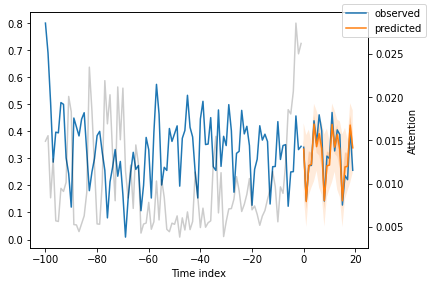

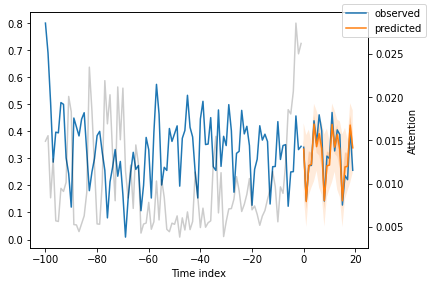

In [94]:
def plot_prediction(
    self,
    x: Dict[str, torch.Tensor],
    out: Dict[str, torch.Tensor],
    idx: int,
    plot_attention: bool = True,
    add_loss_to_title: bool = False,
    show_future_observed: bool = True,
    ax=None,
) -> plt.Figure:
    """
    Plot actuals vs prediction and attention

    Args:
        x (Dict[str, torch.Tensor]): network input
        out (Dict[str, torch.Tensor]): network output
        idx (int): sample index
        plot_attention: if to plot attention on secondary axis
        add_loss_to_title: if to add loss to title. Default to False.
        show_future_observed: if to show actuals for future. Defaults to True.
        ax: matplotlib axes to plot on

    Returns:
        plt.Figure: matplotlib figure
    """
    # plot prediction as normal
    fig = best_model.plot_prediction(
        x, out, idx=idx, add_loss_to_title=add_loss_to_title, show_future_observed=show_future_observed, ax=ax
    )

    # add attention on secondary axis
    if plot_attention:
        interpretation = self.interpret_output(out)
        ax = fig.axes[0]
        ax2 = ax.twinx()
        ax2.set_ylabel("Attention")
        encoder_length = x["encoder_lengths"][idx]
        ax2.plot(
            torch.arange(-encoder_length, 0),
            interpretation["attention"][idx, :encoder_length].detach().cpu(),
            alpha=0.2,
            color="k",
        )
    fig.tight_layout()
    return fig

raw_predictions, x = best_model.predict(val_dataloader, mode = 'raw', return_x=True)

best_model.plot_prediction( x=x,
    out=raw_predictions,
    idx=0)

{'attention': <Figure size 432x288 with 1 Axes>,
 'decoder_variables': <Figure size 504x198 with 1 Axes>,
 'encoder_variables': <Figure size 504x486 with 1 Axes>,
 'static_variables': <Figure size 504x216 with 1 Axes>}

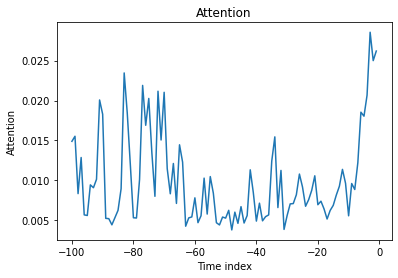

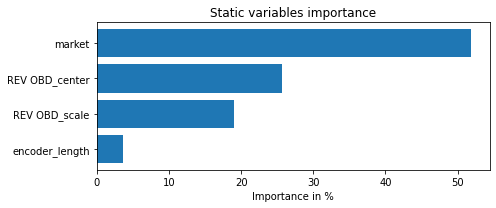

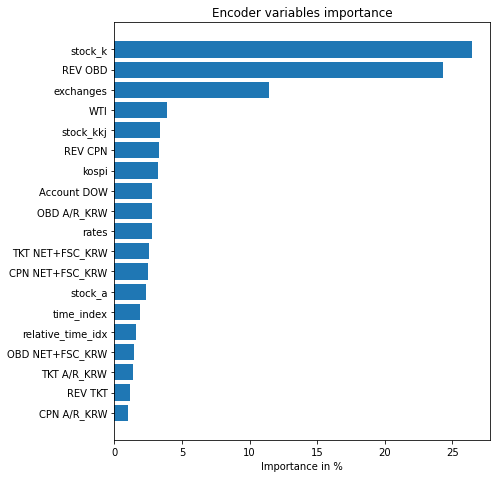

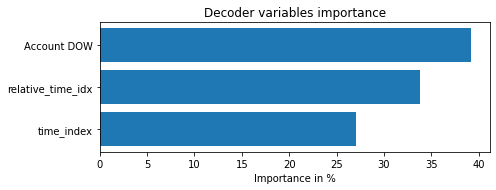

In [96]:
interpretation = best_model.interpret_output(raw_predictions, reduction="sum")
best_model.plot_interpretation(interpretation)